In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [51]:
## Generate dates for 24 months (2 years) MS-month start
dates = pd.date_range(start='2023-01-01', periods=24, freq='MS')

In [52]:
## Create a base trend in sales from 10 to 20 over 24 months
# np.linspace generates 24 evenly spaced numbers between 10 and 20
base_sales = np.linspace(10, 20, 24)

In [53]:
## Define a custom seasonal pattern manually for each month over two years
# December has high peaks,Jan/Feb have dips to simulate realistic seasonal effects
seasonal_pattern = np.array([
    -2, -1, 0, 1, 2, 3, 2, 1, 0, -1, -2, 10, # 1st year
    -2, -1, 0, 1, 2, 3, 2, 1, 0, -1, -2, 12  # 2nd year (slightly higher December)
])

In [54]:
sales_data = base_sales + seasonal_pattern

In [55]:
#add random noise to make data more realistic
np.random.seed(42)
sales_data = sales_data + np.random.normal(0, 0.5, 24)

In [56]:
#avoid negative values
sales_data[sales_data < 0] = 0

In [57]:
#generate dataframe
df = pd.DataFrame({'Sales': sales_data}, index=dates)

In [58]:
df.head(13)

,Sales
2023-01-01,8.248357
2023-02-01,9.365650
2023-03-01,11.193409
2023-04-01,13.065863
2023-05-01,13.622054
2023-06-01,15.056845
2023-07-01,15.398302
2023-08-01,14.427196
2023-09-01,13.243524
2023-10-01,13.184324


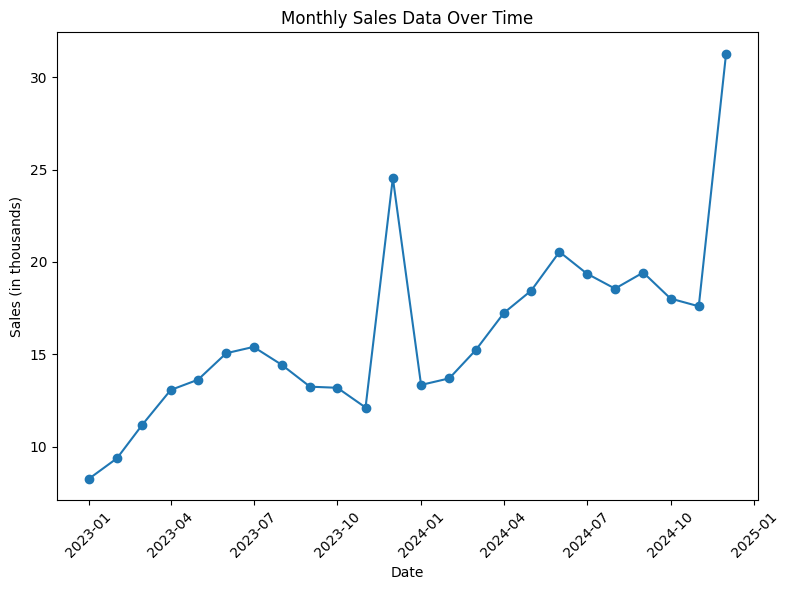

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Data Over Time')
plt.xlabel('Date')
plt.ylabel('Sales (in thousands)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

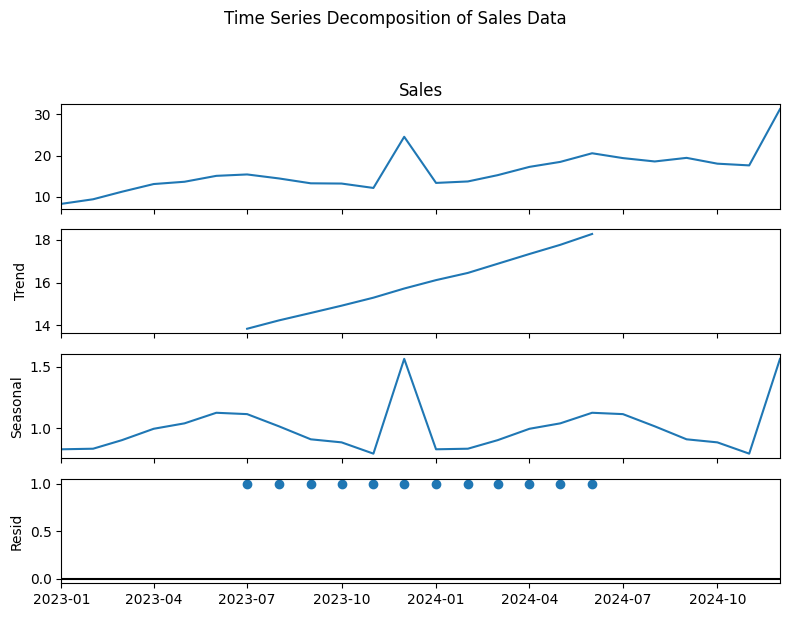

In [60]:
#decomposition: Splits the sales into trend, seasonal, and residual parts.
#helps understand what id happening in the data
#Trend: Long-term increase or decrease
#Seasonal: Regular ups and downs (e.g., Dec peaks)
#Residual: Random noise or unknown factors
decomposition = seasonal_decompose(df['Sales'], model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(8,6)
fig.suptitle('Time Series Decomposition of Sales Data', y=1.02) # Adjust suptitle position
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

In [61]:
#Predict future sales (6 months ahead) by assuming each month will behave like the same month last year.
forecast_periods = 6
last_year_data = df['Sales'].loc['2024-01-01':'2024-12-01']
forecast_values = []
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS') #Creates dates for the 6 months you want to forecast
for i in range(forecast_periods):
    current_month_index = forecast_dates[i].month
    month_to_forecast = forecast_dates[i].month #Gets the month number of the forecasted date further used to ind the same month from last year
    try:
        historical_sales_for_month = df.loc[str(forecast_dates[i].year - 1) + '-' + str(month_to_forecast).zfill(2) + '-01', 'Sales']
        #forecast_dates[i].year - 1 gets the previous year
        #str(month_to_forecast).zfill(2) makes sure the month is 2 digits
    except KeyError:
        #if month missing
        print(f"Warning: Could not find historical data for month {month_to_forecast} in previous year ({forecast_dates[i].year - 1}). Using last known sales value.")
        historical_sales_for_month = df['Sales'].iloc[-1] # Fallback to last value
    forecast_values.append(historical_sales_for_month) #Adds the forecast value for each month by looking up the same month from 1 year ago
    print(f"Forecast for {forecast_dates[i].strftime('%b %Y')}: {historical_sales_for_month:.2f} (based on {forecast_dates[i].strftime('%b')} {forecast_dates[i].year - 1})")


Forecast for Jan 2025: 13.34 (based on Jan 2024)
Forecast for Feb 2025: 13.70 (based on Feb 2024)
Forecast for Mar 2025: 15.22 (based on Mar 2024)
Forecast for Apr 2025: 17.24 (based on Apr 2024)
Forecast for May 2025: 18.45 (based on May 2024)
Forecast for Jun 2025: 20.55 (based on Jun 2024)


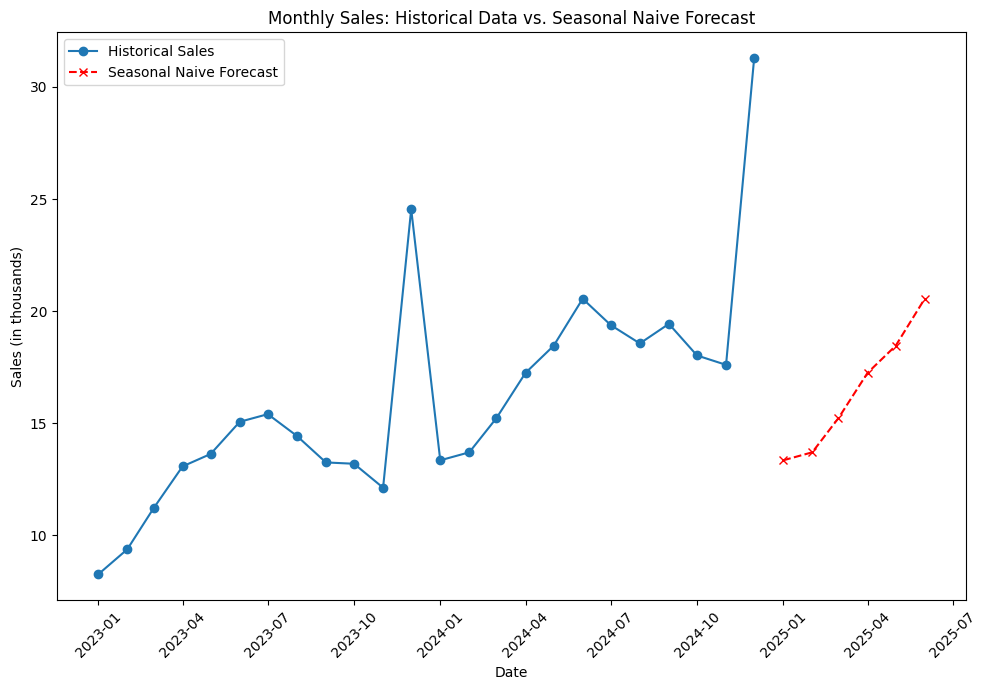

In [62]:
forecast_series = pd.Series(forecast_values, index=forecast_dates)
combined_series = pd.concat([df['Sales'], forecast_series]) #Combines historical sales and future forecasts into one timeline

plt.figure(figsize=(10, 7))
plt.plot(df.index, df['Sales'], label='Historical Sales', marker='o', linestyle='-')
plt.plot(forecast_series.index, forecast_series.values, label='Seasonal Naive Forecast', marker='x', linestyle='--', color='red')
plt.title('Monthly Sales: Historical Data vs. Seasonal Naive Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (in thousands)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
print(forecast_series)

2025-01-01    13.338372
2025-02-01    13.695534
2025-03-01    15.224498
2025-04-01    17.240595
2025-05-01    18.450106
2025-06-01    20.548428
Freq: MS, dtype: float64


In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [65]:
hw_model = ExponentialSmoothing(df['Sales'], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

In [66]:
hw_forecast = hw_fit.forecast(forecast_periods)

In [67]:
combined_hw_series = pd.concat([df['Sales'], hw_forecast])

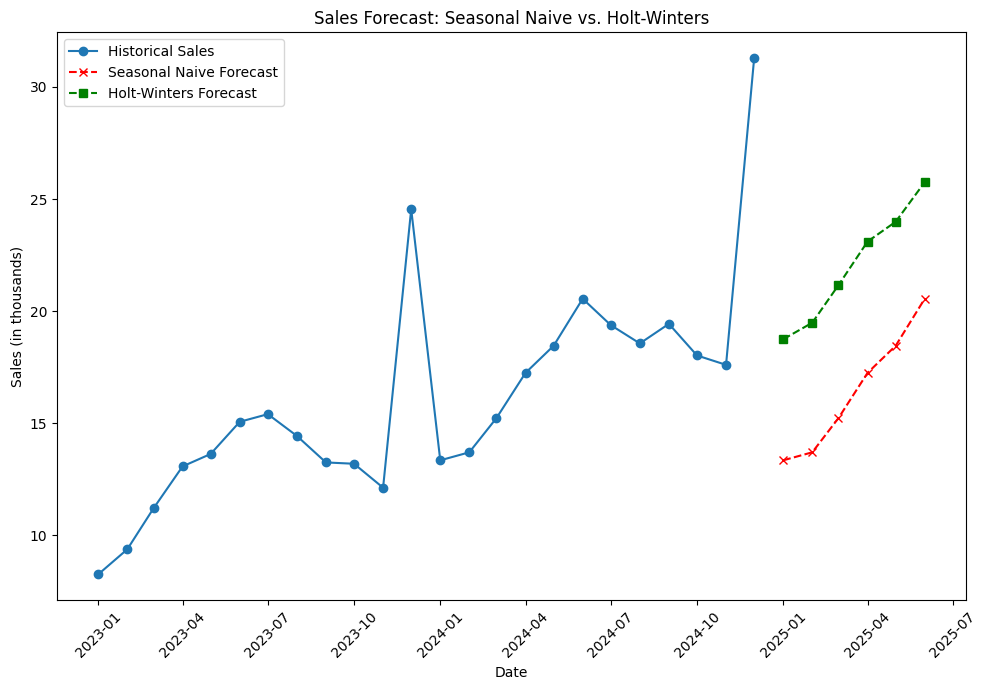

In [70]:
plt.figure(figsize=(10,7))
plt.plot(df.index, df['Sales'], label='Historical Sales', marker='o')
plt.plot(forecast_series.index, forecast_series.values, label='Seasonal Naive Forecast', marker='x', linestyle='--', color='red')
plt.plot(hw_forecast.index, hw_forecast.values, label='Holt-Winters Forecast', marker='s', linestyle='--', color='green')
plt.title('Sales Forecast: Seasonal Naive vs. Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Sales (in thousands)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [71]:
print(hw_forecast)

2025-01-01    18.741779
2025-02-01    19.479003
2025-03-01    21.157362
2025-04-01    23.101637
2025-05-01    23.984491
2025-06-01    25.751047
Freq: MS, dtype: float64
